In [ ]:
PLOTTING


In [2]:
import numpy as np
import matplotlib.pyplot as plt           #We use it for construction of graphs, both 3D and 2D
import math
import matplotlib as mpl
import pandas as pd

import json
import os
import requests

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely
from descartes import PolygonPatch
from tqdm import tqdm
#!conda install -U scikit -learn
from sklearn.neighbors import KNeighborsRegressor




In [19]:
#conda install contextily --channel conda-forge


In [2]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}


url_map = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson" # KOMMUNE DATA
kommuner = gpd.read_file(url_map)

# Convert to metres
kommuner.to_crs({'init':'epsg:25832'},inplace=True) #

bounds = kommuner.bounds

# get min or max of each column

min_max_bounds = []

for columns in bounds.columns[:2]:
    min_max_bounds.append(min(bounds[columns]))
    
for columns in bounds.columns[-2:]:
    min_max_bounds.append(max(bounds[columns]))
min_max_bounds




[441675.99999999994, 6049781.999990508, 892786.9996185575, 6402216.999996983]

<ipython-input-3-530400cb4d98>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  GeoPopData.crs = {'init': 'epsg:3035', 'no_defs': True}
C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\PythonMan\

The CRS is: {'init': 'epsg:25832', 'no_defs': True}
The CRS is: {'init': 'epsg:25832', 'no_defs': True}


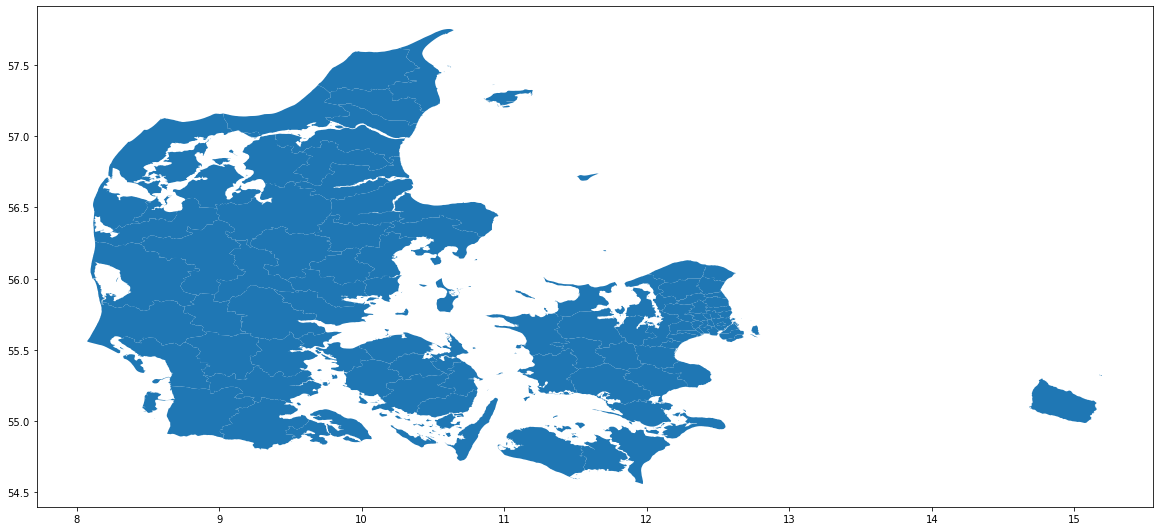

In [3]:
GeoPopData = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/GeoPopData_DK.csv") #POP DATA
#gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
GeoPopData.crs = {'init': 'epsg:3035', 'no_defs': True}
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url)
Kort = kommuner.plot(figsize=(20,20))
kommuner = kommuner.to_crs(epsg = 25832)

#GeoPopData = GeoPopData.to_crs(espg = 25832)

# %%
GeoPopData['latitude'] = [int(x[4:8])*1000 for x in GeoPopData.GRD_ID]
GeoPopData['longtitude'] = [int(x[9:])*1000 for x in GeoPopData.GRD_ID]
#GeoPopData['longtitude'] = GeoPopData['GRD_ID'][9:]

Pop_gdf = gpd.GeoDataFrame(GeoPopData, geometry=gpd.points_from_xy(GeoPopData.longtitude, GeoPopData.latitude))
Pop_gdf.crs = {'init': 'epsg:3035', 'no_defs': True}
Pop_gdf['test'] = Pop_gdf['geometry'].to_crs(epsg = 4326)
Pop_gdf['test2'] = Pop_gdf['geometry'].to_crs(epsg = 3035)
Pop_gdf = Pop_gdf.to_crs(epsg = 25832)
print('The CRS is:', Pop_gdf.crs)

Pop_gdf['latitude'] = [z.y for z in Pop_gdf.geometry]
Pop_gdf['longtitude'] = [z.x for z in Pop_gdf.geometry]
#Pop_gdf
print('The CRS is:', Pop_gdf.crs)

In [3]:
kommuner

,KOMKODE,KOMNAVN,geometry
0,0766,Hedensted,"POLYGON Z ((528116.000 6190641.000 -999.000, 5..."
1,0766,Hedensted,"POLYGON Z ((566517.000 6188004.430 -999.000, 5..."
2,0561,Esbjerg,"POLYGON Z ((474537.000 6154409.000 -999.000, 4..."
3,0849,Jammerbugt,"POLYGON Z ((547480.000 6325805.000 -999.000, 5..."
4,0849,Jammerbugt,"POLYGON Z ((511946.000 6332841.000 -999.000, 5..."
...,...,...,...
306,0461,Odense,"POLYGON Z ((579566.000 6144852.000 -999.000, 5..."
307,0563,Fanø,"POLYGON Z ((463609.000 6134156.000 -999.000, 4..."
308,0563,Fanø,"POLYGON Z ((466675.000 6133266.000 -999.000, 4..."
309,0630,Vejle,"POLYGON Z ((507350.000 6180119.000 -999.000, 5..."


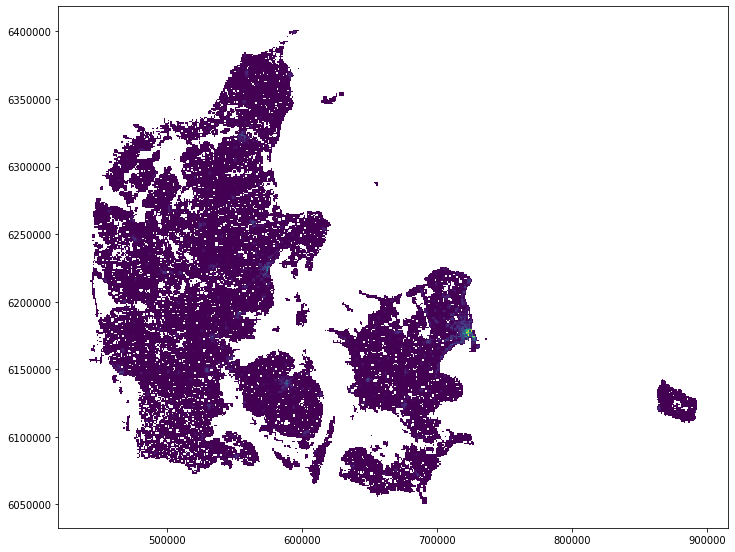

In [10]:
import Function 
import geopandas as gpd
knneg = KNeighborsRegressor(n_neighbors = 25, radius = 25000)

#Pop_gdf['latitude'] = Pop_gdf.geometry.y
#Pop_gdf['longtitude'] = Pop_gdf.geometry.x
#Pop_gdf = Pop_gdf.to_crs(epsg=25832)
square_df = pd.DataFrame(data = Pop_gdf, columns=['latitude','longtitude'])
square_gdf = Function.cell_coords_to_polygons(square_df)
square_gdf = square_gdf.to_crs(epsg=25832)

#square_gdf_join = gpd.sjoin(square_gdf,kommuner)

square_gdf['LA_shifted'] = square_gdf['latitude'] + 500
square_gdf['LO_shifted'] = square_gdf['longtitude'] + 500
#square_gdf_join

# %%
# subset X, y
cols = Pop_gdf[['TOT_P','latitude', 'longtitude']]

X = cols[['longtitude', 'latitude']]

y = cols[['TOT_P']]

KN = KNeighborsRegressor()


KN.fit(X,y)

preds = KN.predict(square_gdf[['LA_shifted', 'LO_shifted']])
                             
square_gdf['pred'] = np.log10(preds)
square_gdf


# %%
new = Pop_gdf[['latitude', 'longtitude', 'TOT_P']]
new_df = pd.merge(square_gdf, new,  how='left', left_on=['latitude','longtitude'], right_on = ['latitude','longtitude'])

empty_list=[]





#%% 
#DETTE ER KODEN VI SKAL BRUGE TIL AT KØRE KORTET MED I SIDSTE ENDE: 
f, ax = plt.subplots(1, figsize=(12, 12))
ax = new_df.plot(column='TOT_P',ax=ax)
plt.show()




In [11]:
gdf = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Main_data_with_geodat.csv")
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitudes, gdf.latitudes))
gdf.crs = {'init': 'epsg:4326', 'no_defs': True}

gdf = gdf.to_crs(epsg =25832)
gdf

,Unnamed: 0,Unnamed: 0.1,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,...,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear,geometry,test
0,0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,...,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaN,1966.0,NaN,POINT (710970.146 6172951.975),0.000000
1,1,1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,...,12.355782,NaN,NaN,2008.0,NaN,NaN,NaN,NaN,POINT (709944.269 6196827.876),0.214620
2,2,2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,...,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaN,2016.0,NaN,POINT (868380.605 6140982.861),2.477826
3,3,3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,...,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0,POINT (868380.605 6140982.861),2.477826
4,4,4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,...,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaN,2015.0,NaN,POINT (727844.496 6174656.155),0.269187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,708,708,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,...,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaN,1933.0,NaN,POINT (574436.896 6225235.413),2.214472
679,709,709,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,...,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaN,1936.0,NaN,POINT (572348.706 6224103.984),2.245289
680,710,710,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,...,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaN,1905.0,NaN,POINT (531696.592 6295478.660),3.057411
681,711,711,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,...,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0,POINT (566502.580 6137726.088),2.320460


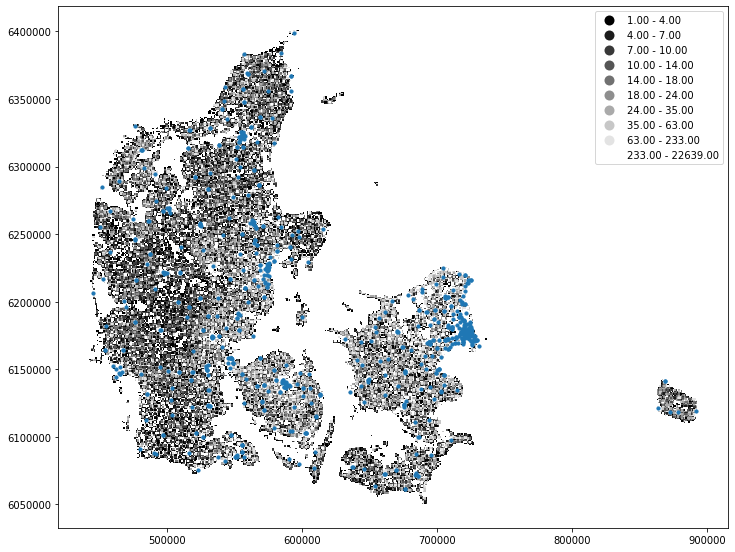

In [15]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax= new_df.plot(column='TOT_P',ax=ax, legend=True, cmap='gray', scheme='quantiles', k=10, linewidth=0.1)
gdf['geometry'].plot(ax=ax , markersize=10)
plt.show()

In [ ]:
DK_shape = gpd.read_file(
  r"C:\Users\Nicklas Lindegaard\Desktop\Speciale\Python\thesis_2020 - midl\Shapefiles")


In [22]:
gdf_Type6 = gdf[(gdf.TypeID==6) | (gdf.Slyear > 2006.0)  ] 
gdf_Type7 = gdf[(gdf.TypeID==7) | (gdf.Slyear > 2006.0) ] 
gdf_Type8 = gdf[(gdf.TypeID==8) | (gdf.Slyear > 2006.0)] 
#test = gdf_Type6[(gdf.Slyear>2006) | (gdf.Slyear>2006).isnull()]
len(gdf_Type6)+len(gdf_Type7)+len(gdf_Type8)


961

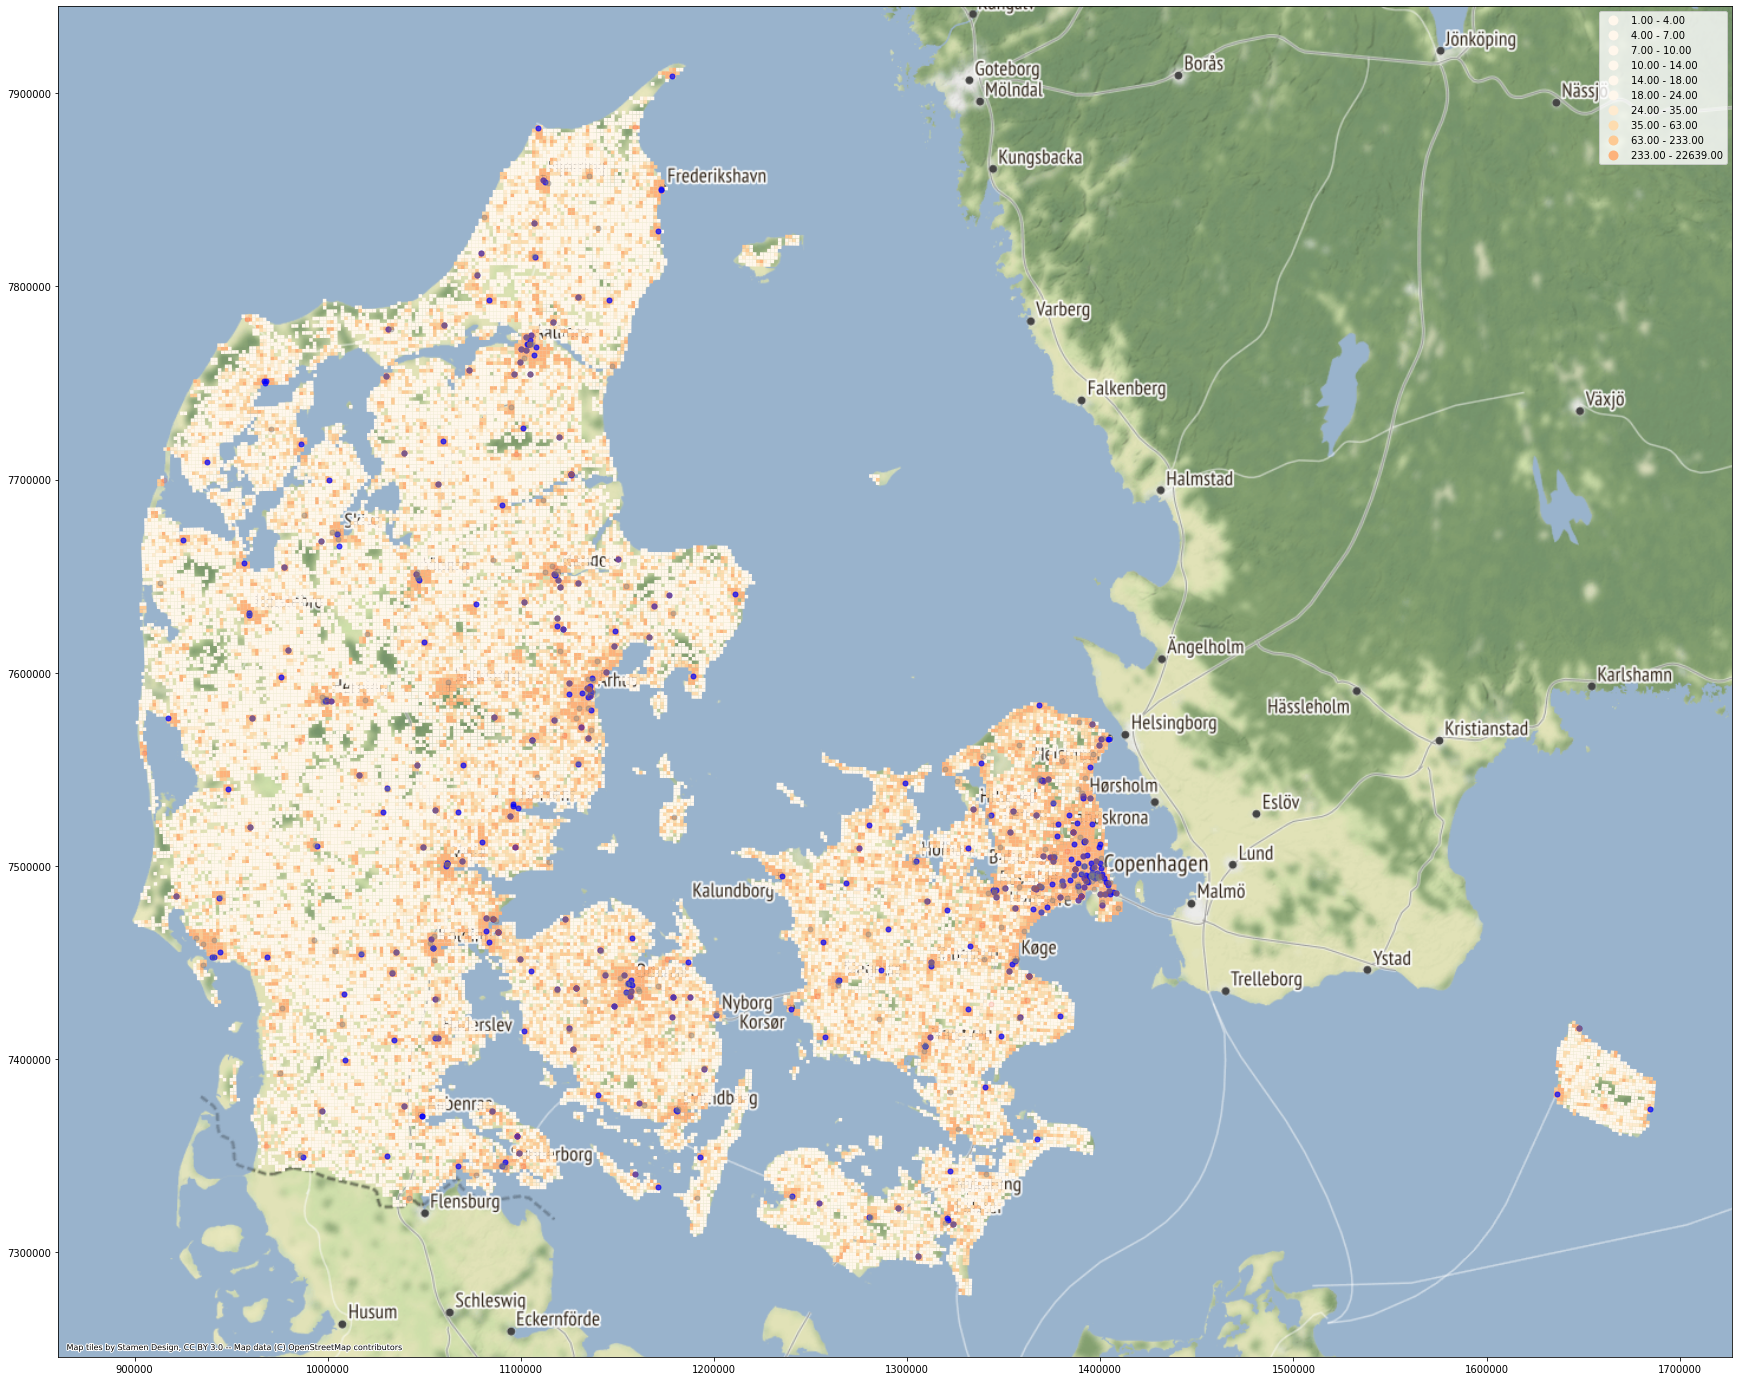

In [27]:
import contextily as ctx  # Husk at køre denne linje første gang for background map 
new_df = new_df.to_crs(epsg =  3857)
gdf = gdf.to_crs(epsg =3857)
f, ax = plt.subplots(1, figsize=(30, 30))
ax = new_df.plot(column='TOT_P',ax=ax, legend=True, cmap='OrRd',norm=mpl.colors.Normalize(vmin=5, vmax=15), scheme='quantiles', k=10)
ctx.add_basemap(ax)
gdf_Type6['geometry'].plot(ax=ax , markersize=25, color='blue' ,  alpha=0.7)
gdf_Type7['geometry'].plot(ax=ax , markersize=25, color='grey', alpha=0.4)
gdf_Type8['geometry'].plot(ax=ax , markersize=25, color='red', alpha=0.1)
plt.show()

## Herfra koder vi distancer imellem hvert apotek i hele Danmark, samt beregner den gennemsnitlige afstand til et apotek for populationen. 

In [33]:
gdf = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Main_data_medstartdato.csv")
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitudes, gdf.latitudes))
gdf

,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2,latitudes,longitudes,Stdato,Sldato,Styear,Slyear,dummy,geometry
0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,"01Jan1966 0:00:00,000",NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,NaN,1966.0,NaN,2008.0,POINT (12.35370 55.65651)
1,2,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,07.03.2008,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,2008-07-03,NaN,2008.0,NaN,2008.0,POINT (12.35578 55.87112)
2,3,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,"01May2016 0:00:00,000",NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,NaN,2016.0,NaN,2016.0,POINT (14.80230 55.27712)
3,5,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,"21Sep2015 0:00:00,000",NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,NaN,2015.0,NaN,2015.0,POINT (12.62277 55.66418)
4,6,022-1,Antvorskov Apotek,7,Idagårdsvej 1,4200.0,"01Jun2018 0:00:00,000",NaN,1085.0,330.0,1085.0,"Idagårdsvej 1, 4200 Denmark",55.390492,11.355228,2018-06-01,NaN,2018.0,NaN,2018.0,POINT (11.35523 55.39049)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,724,178,Aarhus Vejlby Apotek,6,Vejlbygade 16 A,8240.0,01-01-1899 00:00,NaN,1082.0,751.0,1082.0,"Vejlbygade 16 A, 8240 Denmark",56.195078,10.213893,1899-01-01,NaN,1899.0,NaN,2008.0,POINT (10.21389 56.19508)
551,725,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,"01Jan1933 0:00:00,000",NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.172558,10.153505,1933-01-01,NaN,1933.0,NaN,2008.0,POINT (10.15350 56.17256)
552,726,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,"01Jan1936 0:00:00,000",NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,NaN,1936.0,NaN,2008.0,POINT (10.16477 56.15646)
553,727,259,Aars Apotek,6,Søndergade 34,9600.0,"01Jan1905 0:00:00,000",NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,NaN,1905.0,NaN,2008.0,POINT (9.51902 56.80211)


In [34]:
#Kommunekode_list = list(gdf["Kommune"])
#frames_Kommune = {}



100%|████████████████████████████████████████████████████████████████████████████████| 555/555 [00:35<00:00, 15.48it/s]


In [35]:
gdf = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Main_data_medstartdato.csv")
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitudes, gdf.latitudes))
gdf

,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,...,Aarhus Marselisborg Apotek,Aarhus Sct. Lukas Apotek,Aarhus Stjerne Apotek,Aarhus Svane Apotek,Aarhus Trøjborg Apotek,Aarhus Vejlby Apotek,Aarhus Viby Apotek,Aarhus Åbyhøj Apotek,Aars Apotek,Aarup Apotek
0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,"01Jan1966 0:00:00,000",NaN,1084.0,165.0,...,142.932882,145.256942,145.857326,144.962551,144.935942,146.132250,148.623507,147.317558,216.595408,148.419767
1,2,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,07.03.2008,NaN,1084.0,201.0,...,136.097874,137.859831,137.948634,137.331721,137.054378,137.850362,140.896761,139.827429,203.172676,154.898439
2,3,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,"01May2016 0:00:00,000",NaN,1084.0,400.0,...,302.315002,304.391963,304.722399,303.977236,303.813518,304.775153,307.598282,306.412568,369.258654,300.925492
3,5,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,"21Sep2015 0:00:00,000",NaN,1084.0,101.0,...,158.454384,160.627403,161.078398,160.264197,160.162743,161.239032,163.906342,162.666516,229.763195,165.169639
4,6,022-1,Antvorskov Apotek,7,Idagårdsvej 1,4200.0,"01Jun2018 0:00:00,000",NaN,1085.0,330.0,...,107.512093,111.099300,113.098011,111.527662,112.237004,114.428504,114.927035,113.123810,193.915178,82.612456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,724,178,Aarhus Vejlby Apotek,6,Vejlbygade 16 A,8240.0,01-01-1899 00:00,NaN,1082.0,751.0,...,9.330086,5.579775,2.360289,4.181449,2.712224,0.000000,4.498406,5.261659,79.842452,91.346875
551,725,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,"01Jan1933 0:00:00,000",NaN,1082.0,751.0,...,7.665224,3.828620,3.090411,3.674747,3.901923,4.498406,0.000000,1.921395,80.110318,88.497177
552,726,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,"01Jan1936 0:00:00,000",NaN,1082.0,751.0,...,5.757138,2.103389,3.129618,2.588856,3.571583,5.261659,1.921395,0.000000,82.015514,86.768895
553,727,259,Aars Apotek,6,Søndergade 34,9600.0,"01Jan1905 0:00:00,000",NaN,1081.0,820.0,...,87.772498,83.868223,81.436180,83.165833,82.232939,79.842452,80.110318,82.015514,0.000000,161.610641


,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2,latitudes,longitudes,Stdato,Sldato,Styear,Slyear,dummy,geometry
0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,"01Jan1966 0:00:00,000",NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,NaN,1966.0,NaN,2008.0,POINT (12.35370 55.65651)
1,1,412,Allerød Apotek,6,Mølcks Passage 5,2620.0,01.01.1992,31.03.2008,1084.0,201.0,1084.0,"Mølcks Passage 5, 2620 Denmark",55.870360,12.356082,1992-01-01,2008-03-31,1992.0,2008.0,2008.0,POINT (12.35608 55.87036)
2,2,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,07.03.2008,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,2008-07-03,NaN,2008.0,NaN,2008.0,POINT (12.35578 55.87112)
3,3,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,"01May2016 0:00:00,000",NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,NaN,2016.0,NaN,2016.0,POINT (14.80230 55.27712)
4,4,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,"01May2016 0:00:00,000",1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,2016-05-01,1898.0,2016.0,2008.0,POINT (14.80230 55.27712)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,725,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,"01Jan1933 0:00:00,000",NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.172558,10.153505,1933-01-01,NaN,1933.0,NaN,2008.0,POINT (10.15350 56.17256)
726,726,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,"01Jan1936 0:00:00,000",NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,NaN,1936.0,NaN,2008.0,POINT (10.16477 56.15646)
727,727,259,Aars Apotek,6,Søndergade 34,9600.0,"01Jan1905 0:00:00,000",NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,NaN,1905.0,NaN,2008.0,POINT (9.51902 56.80211)
728,728,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,"31Dec2008 0:00:00,000",1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,2008-12-31,1859.0,2008.0,2008.0,POINT (10.04961 55.38131)


In [50]:
Pop_gdf

,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT,latitude,longtitude,geometry,test,test2,LA_shifted,LO_shifted
0,2,1kmN3623E4468,DK,A,2011,DK,0,6.176619e+06,709707.765802,POINT (709707.766 6176619.091),POINT (12.33647 55.68996),POINT (12.33647 55.68996),6.177119e+06,710207.765802
1,1,1kmN3623E4469,DK,A,2011,DK,0,6.176635e+06,710707.257516,POINT (710707.258 6176634.710),POINT (12.35235 55.68966),POINT (12.35235 55.68966),6.177135e+06,711207.257516
2,3,1kmN3623E4470,DK,A,2011,DK,0,6.176650e+06,711706.755173,POINT (711706.755 6176650.337),POINT (12.36823 55.68937),POINT (12.36823 55.68937),6.177150e+06,712206.755173
3,3,1kmN3624E4468,DK,A,2011,DK,0,6.177620e+06,709692.928955,POINT (709692.929 6177619.652),POINT (12.33700 55.69894),POINT (12.33700 55.69894),6.178120e+06,710192.928955
4,7,1kmN3624E4469,DK,A,2011,DK,0,6.177635e+06,710692.417811,POINT (710692.418 6177635.275),POINT (12.35288 55.69864),POINT (12.35288 55.69864),6.178135e+06,711192.417811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39002,2,1kmN3833E4337,DK,A,2011,DK,0,6.384747e+06,575739.157910,POINT (575739.158 6384747.374),POINT (10.26724 57.59876),POINT (10.26724 57.59876),6.385247e+06,576239.157910
39003,8,1kmN3833E4338,DK,A,2011,DK,0,6.384762e+06,576737.419233,POINT (576737.419 6384762.284),POINT (10.28395 57.59872),POINT (10.28395 57.59872),6.385262e+06,577237.419233
39004,3,1kmN3833E4339,DK,A,2011,DK,0,6.384777e+06,577735.682356,POINT (577735.682 6384777.206),POINT (10.30065 57.59869),POINT (10.30065 57.59869),6.385277e+06,578235.682356
39005,3,1kmN3833E4340,DK,A,2011,DK,0,6.384792e+06,578733.947311,POINT (578733.947 6384792.140),POINT (10.31735 57.59865),POINT (10.31735 57.59865),6.385292e+06,579233.947311


In [5]:
Pop_gdf = Pop_gdf.to_crs(epsg = 25832)
Pop_gdf['LA_shifted'] = Pop_gdf['latitude'] + 500
Pop_gdf['LO_shifted'] = Pop_gdf['longtitude'] + 500
Pop_gdf2 = gpd.GeoDataFrame(Pop_gdf, geometry=gpd.points_from_xy(Pop_gdf.LO_shifted, Pop_gdf.LA_shifted))
#gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitudes, gdf.latitudes))
#Pop_gdf['test2'] = gpd.GeoSeries(Pop_gdf['LA_shifted'],)
Pop_gdf2.crs = {'init': 'epsg:25832', 'no_defs': True}
Pop_gdf2 = Pop_gdf2.to_crs(epsg = 4326)
#type(Pop_gdf['test2'])


C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT,latitude,longtitude,geometry,test,test2,LA_shifted,LO_shifted
0,2,1kmN3623E4468,DK,A,2011,DK,0,6.176619e+06,709707.765802,POINT (12.34479 55.69422),POINT (12.33647 55.68996),POINT (4468000.000 3623000.000),6.177119e+06,710207.765802
1,1,1kmN3623E4469,DK,A,2011,DK,0,6.176635e+06,710707.257516,POINT (12.36068 55.69393),POINT (12.35235 55.68966),POINT (4469000.000 3623000.000),6.177135e+06,711207.257516
2,3,1kmN3623E4470,DK,A,2011,DK,0,6.176650e+06,711706.755173,POINT (12.37656 55.69363),POINT (12.36823 55.68937),POINT (4470000.000 3623000.000),6.177150e+06,712206.755173
3,3,1kmN3624E4468,DK,A,2011,DK,0,6.177620e+06,709692.928955,POINT (12.34532 55.70321),POINT (12.33700 55.69894),POINT (4468000.000 3624000.000),6.178120e+06,710192.928955
4,7,1kmN3624E4469,DK,A,2011,DK,0,6.177635e+06,710692.417811,POINT (12.36121 55.70291),POINT (12.35288 55.69864),POINT (4469000.000 3624000.000),6.178135e+06,711192.417811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39002,2,1kmN3833E4337,DK,A,2011,DK,0,6.384747e+06,575739.157910,POINT (10.27576 57.60316),POINT (10.26724 57.59876),POINT (4337000.000 3833000.000),6.385247e+06,576239.157910
39003,8,1kmN3833E4338,DK,A,2011,DK,0,6.384762e+06,576737.419233,POINT (10.29247 57.60313),POINT (10.28395 57.59872),POINT (4338000.000 3833000.000),6.385262e+06,577237.419233
39004,3,1kmN3833E4339,DK,A,2011,DK,0,6.384777e+06,577735.682356,POINT (10.30917 57.60309),POINT (10.30065 57.59869),POINT (4339000.000 3833000.000),6.385277e+06,578235.682356
39005,3,1kmN3833E4340,DK,A,2011,DK,0,6.384792e+06,578733.947311,POINT (10.32588 57.60305),POINT (10.31735 57.59865),POINT (4340000.000 3833000.000),6.385292e+06,579233.947311


In [79]:
from tqdm import tnrange ,tqdm_notebook

In [1]:
min_dist = []
for i in range(len(Pop_gdf2['geometry'])):
    midl_list = []
    for z in range(len(gdf['geometry'])):
        midl_list.append(Function.haversine(Pop_gdf2['geometry'][i],gdf['geometry'][z]))
    min_dist.append(np.min(midl_list)) 
gdf['min_dist'] = min_dist        


In [ ]:
gdf = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Main_data_medstartdato.csv")
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitudes, gdf.latitudes))
gdf

https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/%C3%85rsdata/APOTEK_M_UDS_M_OMS_M_IND_2008.csv


In [6]:
#MONSTER LOOP. Carefull running it, med apoteksudsalg.  
import Function
d = {}
d2 = {}
for i in tqdm(range(2008,2009)):
    filename = "https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/%C3%85rsdata/APOTEK_M_UDS_M_OMS_M_IND_" + str(i) + ".csv"
    name = "year_" + str(i)
    d[name] = pd.read_csv(filename)
    d[name] = gpd.GeoDataFrame(d[name], geometry=gpd.points_from_xy(d[name].longitudes, d[name].latitudes))
    for z in range(len(d[name]["Navn"])):
        result = []
        for x in range(len(d[name]["Navn"])):
            #print(len(frames_Kommune[str(i)]))
            result.append(Function.haversine(d[name]['geometry'][z],d[name]['geometry'][x]))
            #print(len(result))
        d[name][d[name]['Navn'][z]] = result
    min_dist = []
    for i in range(len(Pop_gdf2['geometry'])):
        midl_list = []
        for z in range(len(d[name]['geometry'])):
            midl_list.append(Function.haversine(Pop_gdf2['geometry'][i],d[name]['geometry'][z]))
        min_dist.append(np.min(midl_list)) 
    d2[name] = Pop_gdf2.copy()
    d2[name]['min_dist'] = min_dist
    
    

In [7]:
#MONSTER LOOP. Carefull running it, uden apoteksudsalg.  
import Function
d = {}
d2 = {}
for i in tqdm(range(2008,2019)):
    filename = "https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/%C3%85rsdata/APOTEK_u_UDS_M_OMS_M_IND_" + str(i) + ".csv"
    name = "year_" + str(i)
    d[name] = pd.read_csv(filename)
    d[name] = gpd.GeoDataFrame(d[name], geometry=gpd.points_from_xy(d[name].longitudes, d[name].latitudes))
    for z in range(len(d[name]["Navn"])):
        result = []
        for x in range(len(d[name]["Navn"])):
            #print(len(frames_Kommune[str(i)]))
            result.append(Function.haversine(d[name]['geometry'][z],d[name]['geometry'][x]))
            #print(len(result))
        d[name][d[name]['Navn'][z]] = result
    min_dist = []
    for t in range(len(Pop_gdf2['geometry'])):
        midl_list = []
        for u in range(len(d[name]['geometry'])):
            midl_list.append(Function.haversine(Pop_gdf2['geometry'][t],d[name]['geometry'][u]))
        min_dist.append(np.min(midl_list)) 
    d2[name] = Pop_gdf2.copy()
    d2[name]['min_dist'] = min_dist
    d2[name].to_csv("Min_afstand_u_udsalg" + str(i) + ".csv")

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [2:03:19<00:00, 672.73s/it]


In [58]:
for i in tqdm(range(2008,2019)):
    name = "year_" + str(i)
    d2[name].to_csv("Min_afstand_" + str(i) + ".csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.13s/it]


In [8]:
display(d2[2008].head(20))

KeyError: 2008

In [223]:
data = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/%C3%85rsdata/Min_afstand_2008.csv")
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longtitude, data.latitude))
data.crs = {'init': 'epsg:25832', 'no_defs': True}
data = data.to_crs(epsg = 4326)

data

,Unnamed: 0,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT,latitude,longtitude,geometry,test,test2,LA_shifted,LO_shifted,min_dist
0,0,2,1kmN3623E4468,DK,A,2011,DK,0,6.176619e+06,709707.765802,POINT (12.33647 55.68996),POINT (12.33646700763913 55.68995500950111),POINT (4468000 3623000),6.177119e+06,710207.765802,2.877391
1,1,1,1kmN3623E4469,DK,A,2011,DK,0,6.176635e+06,710707.257516,POINT (12.35235 55.68966),POINT (12.35235054158323 55.68966235283942),POINT (4469000 3623000),6.177135e+06,711207.257516,2.812565
2,2,3,1kmN3623E4470,DK,A,2011,DK,0,6.176650e+06,711706.755173,POINT (12.36823 55.68937),POINT (12.36823385610069 55.68936771425528),POINT (4470000 3623000),6.177150e+06,712206.755173,3.086412
3,3,3,1kmN3624E4468,DK,A,2011,DK,0,6.177620e+06,709692.928955,POINT (12.33700 55.69894),POINT (12.33699667562083 55.69893659409576),POINT (4468000 3624000),6.178120e+06,710192.928955,1.921181
4,4,7,1kmN3624E4469,DK,A,2011,DK,0,6.177635e+06,710692.417811,POINT (12.35288 55.69864),POINT (12.35288380384644 55.69864386184377),POINT (4469000 3624000),6.178135e+06,711192.417811,1.823018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39002,39002,2,1kmN3833E4337,DK,A,2011,DK,0,6.384747e+06,575739.157910,POINT (10.26724 57.59876),POINT (10.26724347181574 57.59875869432035),POINT (4337000 3833000),6.385247e+06,576239.157910,8.071471
39003,39003,8,1kmN3833E4338,DK,A,2011,DK,0,6.384762e+06,576737.419233,POINT (10.28395 57.59872),POINT (10.28394602278891 57.59872405003636),POINT (4338000 3833000),6.385262e+06,577237.419233,7.086069
39004,39004,3,1kmN3833E4339,DK,A,2011,DK,0,6.384777e+06,577735.682356,POINT (10.30065 57.59869),POINT (10.30064854357797 57.59868730613451),POINT (4339000 3833000),6.385277e+06,578235.682356,6.103849
39005,39005,3,1kmN3833E4340,DK,A,2011,DK,0,6.384792e+06,578733.947311,POINT (10.31735 57.59865),POINT (10.31735103240753 57.59864846262111),POINT (4340000 3833000),6.385292e+06,579233.947311,5.126639


In [247]:
kommuner = kommuner.to_crs(epsg = 4326)
data_kom = gpd.sjoin(data , kommuner)
data_kom_all = gpd.sjoin(data , kommuner, how='left')
data_null = data_kom_all[(data_test.KOMKODE.isnull())]
data_null = data_null.reset_index(drop=True)
data_kom

,Unnamed: 0,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT,latitude,longtitude,geometry,test,test2,LA_shifted,LO_shifted,min_dist,index_right,KOMKODE,KOMNAVN
0,0,2,1kmN3623E4468,DK,A,2011,DK,0,6.176619e+06,709707.765802,POINT (12.33647 55.68996),POINT (12.33646700763913 55.68995500950111),POINT (4468000 3623000),6.177119e+06,710207.765802,2.877391,139,0165,Albertslund
1,1,1,1kmN3623E4469,DK,A,2011,DK,0,6.176635e+06,710707.257516,POINT (12.35235 55.68966),POINT (12.35235054158323 55.68966235283942),POINT (4469000 3623000),6.177135e+06,711207.257516,2.812565,139,0165,Albertslund
2,2,3,1kmN3623E4470,DK,A,2011,DK,0,6.176650e+06,711706.755173,POINT (12.36823 55.68937),POINT (12.36823385610069 55.68936771425528),POINT (4470000 3623000),6.177150e+06,712206.755173,3.086412,139,0165,Albertslund
3,3,3,1kmN3624E4468,DK,A,2011,DK,0,6.177620e+06,709692.928955,POINT (12.33700 55.69894),POINT (12.33699667562083 55.69893659409576),POINT (4468000 3624000),6.178120e+06,710192.928955,1.921181,139,0165,Albertslund
4,4,7,1kmN3624E4469,DK,A,2011,DK,0,6.177635e+06,710692.417811,POINT (12.35288 55.69864),POINT (12.35288380384644 55.69864386184377),POINT (4469000 3624000),6.178135e+06,711192.417811,1.823018,139,0165,Albertslund
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35294,35294,2,1kmN3802E4391,DK,A,2011,DK,0,6.354541e+06,630113.736545,POINT (11.16038 57.31523),POINT (11.16037512215807 57.3152256802631),POINT (4391000 3802000),6.355041e+06,630613.736545,38.964486,270,0825,Læsø
37845,37845,30,1kmN3773E4311,DK,A,2011,DK,0,6.324321e+06,550664.821246,POINT (9.83536 57.05952),POINT (9.835364125778241 57.05952055904698),POINT (4311000 3773000),6.324821e+06,551164.821246,3.621595,94,0851,Aalborg
37846,37846,2,1kmN3773E4312,DK,A,2011,DK,0,6.324336e+06,551663.277665,POINT (9.85183 57.05954),POINT (9.851827665149832 57.05954018164852),POINT (4312000 3773000),6.324836e+06,552163.277665,2.632220,94,0851,Aalborg
37873,37873,6,1kmN3774E4311,DK,A,2011,DK,0,6.325322e+06,550650.199370,POINT (9.83532 57.06851),POINT (9.835324926728006 57.06850997531561),POINT (4311000 3774000),6.325822e+06,551150.199370,3.665301,94,0851,Aalborg


In [215]:

# data['LA_shifted'] = data['latitude'] +250
# data['LO_shifted'] = data['longtitude'] +250
# data_null = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.LO_shifted, data.LA_shifted))
# data_null.crs = {'init': 'epsg:25832', 'no_defs': True}
# data_null = data_null.to_crs(epsg = 4326)
# data_null = data_null.drop(['index_right'], axis=1)
# data_null_join = gpd.sjoin(data_null, kommuner, how="left")
# data.crs = {'init': 'epsg:25832', 'no_defs': True}
# data = data.to_crs(epsg = 4326)
# data =data.reset_index(drop=True)
#print(data_null_join[(data_null_join.KOMKODE_right.isnull())])

C:\Users\nickl\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nickl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [243]:
from shapely.geometry import Point, Polygon
import geopandas as gpd

water_kom_Kode = []
water_kom_Navn = []


for i in range(len(data_null)):
    red_point = data_null['geometry'][i]
    polygon_index = kommuner['geometry'].distance(red_point).sort_values().index[0]
    water_kom_Navn.append(kommuner.loc[polygon_index][1])
    water_kom_Kode.append(kommuner.loc[polygon_index][])
    

In [273]:
data_null['KOMKODE']=water_kom_Kode
data_null['KOMNAVN']=water_kom_Navn
data_kom.append(data_null)

for kode in data_null['KOMKODE']:
    for i in range(len(data_kom_all)):
        if data_kom_all['KOMKODE'][i] is np.nan:
            data_kom_all['KOMKODE'][i] = kode
            break

C:\Users\nickl\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [285]:
for navn in tqdm(data_null['KOMNAVN']):
    for i in range(len(data_kom_all)):
        if data_kom_all['KOMNAVN'][i] is np.nan:
            data_kom_all['KOMNAVN'][i] = navn
            break

  0%|                                                                                         | 0/1489 [00:00<?, ?it/s]C:\Users\nickl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████████████████████████████████████████████████████████████████████████| 1489/1489 [07:45<00:00,  3.20it/s]


In [286]:
for i in range(2009,2019):
    file = "https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/%C3%85rsdata/Min_afstand_" + str(i) + ".csv"
    indata = pd.read_csv(file)
    varname = 'min_dist_' + str(i)
    data_kom_all[varname] = indata['min_dist']

In [288]:
data_kom_all.to_csv('Min_data_all_years.csv')

In [148]:
kommuner

,KOMKODE,KOMNAVN,geometry
0,0766,Hedensted,"POLYGON Z ((9.44919 55.86046 -999.00000, 9.460..."
1,0766,Hedensted,"POLYGON Z ((10.06198 55.83301 -999.00000, 10.0..."
2,0561,Esbjerg,"POLYGON Z ((8.59656 55.53506 -999.00000, 8.601..."
3,0849,Jammerbugt,"POLYGON Z ((9.78314 57.07319 -999.00000, 9.781..."
4,0849,Jammerbugt,"POLYGON Z ((9.19738 57.13868 -999.00000, 9.207..."
...,...,...,...
306,0461,Odense,"POLYGON Z ((10.25777 55.44339 -999.00000, 10.2..."
307,0563,Fanø,"POLYGON Z ((8.42607 55.35239 -999.00000, 8.417..."
308,0563,Fanø,"POLYGON Z ((8.47452 55.34461 -999.00000, 8.474..."
309,0630,Vejle,"POLYGON Z ((9.11714 55.76669 -999.00000, 9.100..."


In [ ]:
min_dist = []
for i in range(len(Pop_gdf2['geometry'])):
    midl_list = []
    for z in range(len(gdf['geometry'])):
        midl_list.append(Function.haversine(Pop_gdf2['geometry'][i],gdf['geometry'][z]))
    min_dist.append(np.min(midl_list)) 
gdf['min_dist'] = min_dist        


In [ ]:
min_dist = []
for i, point in enumerate(points):
    min_dist[i] = np.min([point.distance(line) for line in lines])
gdf['min_dist'] = min_dist
df_points.head(3)